# Copper Prices Prediction - Q4

## Data Preprocessing

In [2]:
#load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os as os
import sys as sys
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

In [3]:
df = pd.read_csv('Copper Futures Historical Data.csv')

In [4]:
df.shape

(23, 7)

In [5]:
df.head() #show some of the data

,Date,Price,Open,High,Low,Vol.,Change %
0,08/29/2023,3.8022,3.7985,3.8083,3.7905,NaN,0.27%
1,08/28/2023,3.7920,3.7950,3.8290,3.7800,NaN,-0.28%
2,08/27/2023,3.8027,3.7887,3.8057,3.7887,NaN,0.49%
3,08/25/2023,3.7840,3.7890,3.8290,3.7655,44.88K,-0.25%
4,08/24/2023,3.7935,3.8365,3.8390,3.7860,36.27K,-1.15%


In [6]:
type(df)

pandas.core.frame.DataFrame

In [7]:
dfcolumns = df.columns
dfcolumns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [8]:
dftypes = df.dtypes
for i in range(len(dftypes)):
    print(df[dfcolumns[i]].name,'---------->',dftypes[i])

Date ----------> object
Price ----------> float64
Open ----------> float64
High ----------> float64
Low ----------> float64
Vol. ----------> object
Change % ----------> object


In [9]:
df.info()  ##initial data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      23 non-null     object 
 1   Price     23 non-null     float64
 2   Open      23 non-null     float64
 3   High      23 non-null     float64
 4   Low       23 non-null     float64
 5   Vol.      20 non-null     object 
 6   Change %  23 non-null     object 
dtypes: float64(4), object(3)
memory usage: 1.4+ KB


In [10]:
df.describe() #main statistics of numeric types by default

,Price,Open,High,Low
count,23.000000,23.000000,23.000000,23.000000
mean,3.789691,3.796813,3.828630,3.759139
std,0.083100,0.088468,0.088059,0.077501
min,3.657500,3.647500,3.694000,3.627000
25%,3.722250,3.741000,3.758250,3.691000
50%,3.788500,3.789000,3.829000,3.765500
75%,3.836250,3.843250,3.859750,3.805500
max,4.008000,4.015500,4.024000,3.908000


In [11]:
df.describe(include=['object', 'bool']) #main statistics of object and bool types

,Date,Vol.,Change %
count,23,20,23
unique,23,20,23
top,08/29/2023,44.88K,0.27%
freq,1,1,1


In [12]:
#identify categorical and numerical features
#return 2 lists, Numerical columns and Categorical columns
def types(Dataframe):
    numerical = Dataframe.select_dtypes(exclude = ['object']).columns.tolist()
    categorical = Dataframe.select_dtypes(include = ['object']).columns.tolist()
    return numerical, categorical

In [13]:
#identify duplicated rows
def duplicaterows(Dataframe):
    duplicaterows = Dataframe[Dataframe.duplicated()]
    if duplicaterows.empty:
        print('No duplicated rows found')
        df = Dataframe##don't drop duplicates
    else:
        print(duplicaterows)##drop duplicates
        df = Dataframe.drop_duplicates(keep = 'last', inplace = True)
    return duplicaterows, df

def duplicatecols(Dataframe):
    duplicatecols = Dataframe.columns[Dataframe.columns.duplicated()]
    if duplicatecols.empty:
        print('There are no duplicated cols in this dataframe')
        df = Dataframe##don't drop duplicates
    else:
        print(duplicatecols)
        df = Dataframe.drop(columns = duplicatecols, inplace = True)##drop duplicates
    return duplicatecols, df

In [14]:
#check nulls and duplicates
duplicaterows, df = duplicaterows(df)
duplicatecols, df = duplicatecols(df)

No duplicated rows found
There are no duplicated cols in this dataframe


In [15]:
df_n, df_c = types(df)
print(df_n)
print('_________________________________________\n')
print(df_c)

['Price', 'Open', 'High', 'Low']
_________________________________________

['Date', 'Vol.', 'Change %']


In [16]:
#identify null values
nulllist = []
for i in range(len(dfcolumns)):
    if df[dfcolumns[i]].isna().sum() != 0 :
        nulllist.append(dfcolumns[i])
        
print(nulllist)

['Vol.']


In [17]:
#check fill of df['Vol.']
prefill = df['Vol.'].value_counts().head()
prefill

Vol.
44.88K     1
36.27K     1
109.74K    1
89.27K     1
81.96K     1
Name: count, dtype: int64

In [18]:
#MANUAL FILLING
#fill all null values with max value_count being the most frequent in df
#check if column is null
def manualnullhandling(Dataframe, nulllist):
    for i in range(len(nulllist)):
        series = df[nulllist[i]].value_counts()
        if series.empty == True:
            #fill = 'Default'
            print('Fill:', nulllist[i], ' column with:')
            print('No fill, since column is empty, so drop')
            df.drop(nulllist[i], axis = 1, inplace = True)
        else:
            fill = df[nulllist[i]].value_counts().index[0]
            print('Fill:', nulllist[i], ' column with:')
            print(fill)
            df[nulllist[i]].fillna(fill, inplace = True)
        print('__________________________________________________')

In [19]:
#no top values found so manual filling of nan with most frequent value being the index[0] of value_counts
#simple methods such as simple imputation is expected to perform poorly in a prediction model
#use multivariant methods: iterative or knn
#knn is by default based on nearest distance classifiers
#iterative uses round robin methods to learn about patterns between data, R based
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [20]:
#to use iteratve imputer all data shall be numeric
#convert Date to date time type
#convert Vol. to numeric and change title to Volume in Thousands
#convert Change % to numeric and change title to Percentage Change
df['Date'] = pd.to_datetime(df['Date'])
df['Vol.'] = df['Vol.'].str.replace("K", "")
df['Change %'] = df['Change %'].str.replace("%", "")

In [21]:
df['Date'].dtype

dtype('<M8[ns]')

In [22]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-08-29,3.8022,3.7985,3.8083,3.7905,NaN,0.27
1,2023-08-28,3.7920,3.7950,3.8290,3.7800,NaN,-0.28
2,2023-08-27,3.8027,3.7887,3.8057,3.7887,NaN,0.49
3,2023-08-25,3.7840,3.7890,3.8290,3.7655,44.88,-0.25
4,2023-08-24,3.7935,3.8365,3.8390,3.7860,36.27,-1.15


In [23]:
df['Vol.'] = pd.to_numeric(df['Vol.'])
df['Change %'] = pd.to_numeric(df['Change %'])

In [24]:
df_n, df_c = types(df)
print(df_n)
print('_________________________________________\n')
print(df_c)

['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
_________________________________________

[]


In [25]:
df['Vol.'].dtype

dtype('float64')

In [26]:
df = df.rename(columns = {'Vol.' : 'Vol. in Thousands'})
df = df.rename(columns = {'Change %' : 'Percentage Change'})

In [27]:
df.head()

,Date,Price,Open,High,Low,Vol. in Thousands,Percentage Change
0,2023-08-29,3.8022,3.7985,3.8083,3.7905,NaN,0.27
1,2023-08-28,3.7920,3.7950,3.8290,3.7800,NaN,-0.28
2,2023-08-27,3.8027,3.7887,3.8057,3.7887,NaN,0.49
3,2023-08-25,3.7840,3.7890,3.8290,3.7655,44.88,-0.25
4,2023-08-24,3.7935,3.8365,3.8390,3.7860,36.27,-1.15


In [28]:
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(df.iloc[:,1:])

IterativeImputer(random_state=0)

In [29]:
arraynew = imp.transform(df.iloc[:,1:])
#print(arraynew)
type(arraynew)

numpy.ndarray

In [30]:
dfnew = pd.DataFrame(arraynew, columns = ['Price','Open','High','Low','Vol. in Thousands','Percentage Change'])

In [31]:
dfnew.head(10)  #new dataframe with duplicates and nulls handled

,Price,Open,High,Low,Vol. in Thousands,Percentage Change
0,3.8022,3.7985,3.8083,3.7905,74.212079,0.27
1,3.7920,3.7950,3.8290,3.7800,76.836941,-0.28
2,3.8027,3.7887,3.8057,3.7887,73.149638,0.49
3,3.7840,3.7890,3.8290,3.7655,44.880000,-0.25
4,3.7935,3.8365,3.8390,3.7860,36.270000,-1.15
5,3.8375,3.7900,3.8425,3.7885,42.180000,1.29
6,3.7885,3.7565,3.8095,3.7515,42.540000,1.88
7,3.7185,3.7160,3.7305,3.6845,59.300000,0.34
8,3.7060,3.6880,3.7215,3.6645,54.520000,0.39
9,3.6915,3.6475,3.7195,3.6270,73.410000,0.93


In [32]:
#add date column to get the original df but with null values handled
dfnew['Date'] = df['Date']

In [33]:
dfnew.head()

,Price,Open,High,Low,Vol. in Thousands,Percentage Change,Date
0,3.8022,3.7985,3.8083,3.7905,74.212079,0.27,2023-08-29
1,3.7920,3.7950,3.8290,3.7800,76.836941,-0.28,2023-08-28
2,3.8027,3.7887,3.8057,3.7887,73.149638,0.49,2023-08-27
3,3.7840,3.7890,3.8290,3.7655,44.880000,-0.25,2023-08-25
4,3.7935,3.8365,3.8390,3.7860,36.270000,-1.15,2023-08-24


In [34]:
#or we could replace Vol.in Thousands in df with the dfnew one
df['Vol. in Thousands'] = dfnew['Vol. in Thousands']
df.head()

,Date,Price,Open,High,Low,Vol. in Thousands,Percentage Change
0,2023-08-29,3.8022,3.7985,3.8083,3.7905,74.212079,0.27
1,2023-08-28,3.7920,3.7950,3.8290,3.7800,76.836941,-0.28
2,2023-08-27,3.8027,3.7887,3.8057,3.7887,73.149638,0.49
3,2023-08-25,3.7840,3.7890,3.8290,3.7655,44.880000,-0.25
4,2023-08-24,3.7935,3.8365,3.8390,3.7860,36.270000,-1.15


In [35]:
dfcolumns = df.columns
#dfcolumns

In [36]:
df.isna().sum()   ##no null values

Date                 0
Price                0
Open                 0
High                 0
Low                  0
Vol. in Thousands    0
Percentage Change    0
dtype: int64

In [37]:
#check fill of df['Vol.']
postfill = df['Vol. in Thousands'].value_counts()
postfill.head()

Vol. in Thousands
74.212079     1
73.510000     1
109.740000    1
89.270000     1
81.960000     1
Name: count, dtype: int64

In [38]:
#print top 5 most frequent values of each column
for i in range(len(dfcolumns)):
    print(df[dfcolumns[i]].value_counts().head())
    print("_____________________________________")

Date
2023-08-29    1
2023-08-14    1
2023-08-01    1
2023-08-02    1
2023-08-03    1
Name: count, dtype: int64
_____________________________________
Price
3.8022    1
3.7255    1
3.9085    1
3.8435    1
3.8995    1
Name: count, dtype: int64
_____________________________________
Open
3.7985    1
3.7185    1
4.0155    1
3.9100    1
3.8445    1
Name: count, dtype: int64
_____________________________________
High
3.8290    2
3.8083    1
4.0240    1
3.9210    1
3.9040    1
Name: count, dtype: int64
_____________________________________
Low
3.7905    1
3.6870    1
3.9040    1
3.8340    1
3.8205    1
Name: count, dtype: int64
_____________________________________
Vol. in Thousands
74.212079     1
73.510000     1
109.740000    1
89.270000     1
81.960000     1
Name: count, dtype: int64
_____________________________________
Percentage Change
 0.27    1
 0.17    1
-2.48    1
-1.66    1
 1.46    1
Name: count, dtype: int64
_____________________________________


4.008


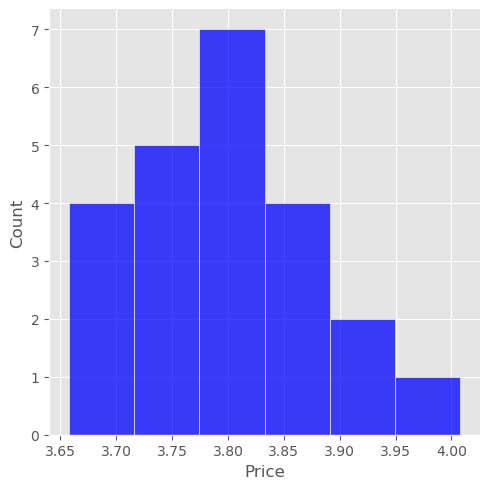

In [39]:
#count plot for values of Price ##Univariate
print(df['Price'].max())
sns.displot(df['Price'], color = 'blue')

<Axes: >

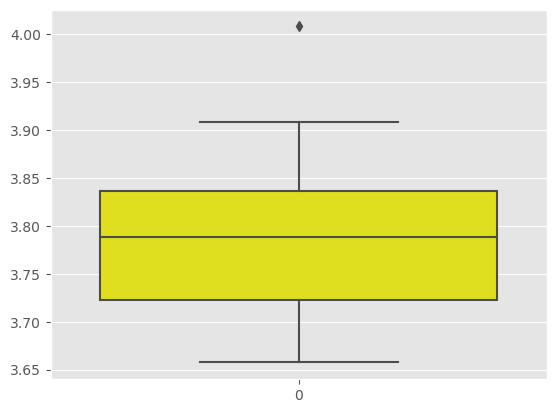

In [40]:
#box plot to show range of values  ##Univariate  ##used to check for outliers
sns.boxplot(df['Price'], color = 'yellow')

<Axes: >

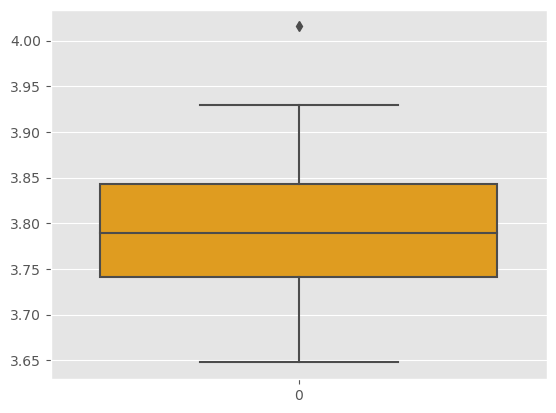

In [41]:
#box plot to show range of values  ##Univariate  ##used to check for outliers
sns.boxplot(df['Open'], color = 'orange')
##position of outlier
##print(np.where((df['Price'] > 4) & (df['Open'] > 4)))

<Axes: >

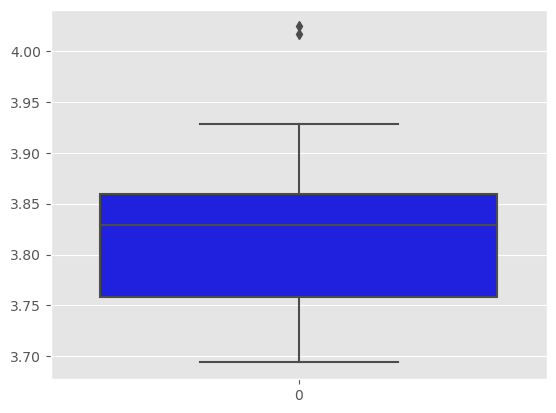

In [42]:
#box plot to show range of values  ##Univariate  ##used to check for outliers
sns.boxplot(df['High'], color = 'blue')

<Axes: >

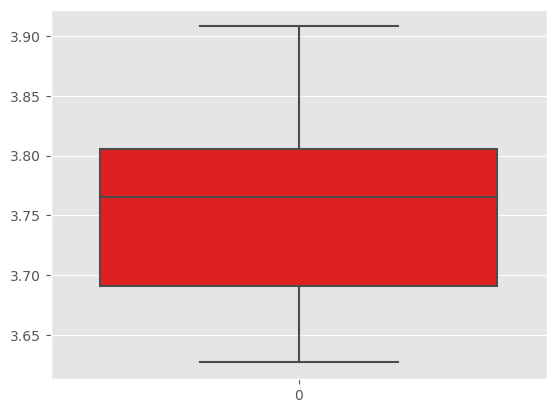

In [43]:
#box plot to show range of values  ##Univariate  ##used to check for outliers
sns.boxplot(df['Low'], color = 'red')

<Axes: >

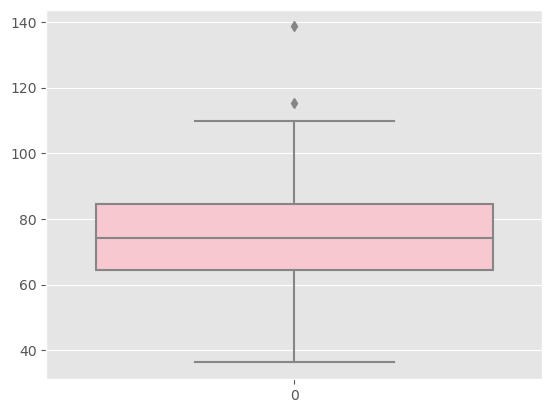

In [44]:
#box plot to show range of values  ##Univariate  ##used to check for outliers
sns.boxplot(df['Vol. in Thousands'], color = 'pink')

<Axes: >

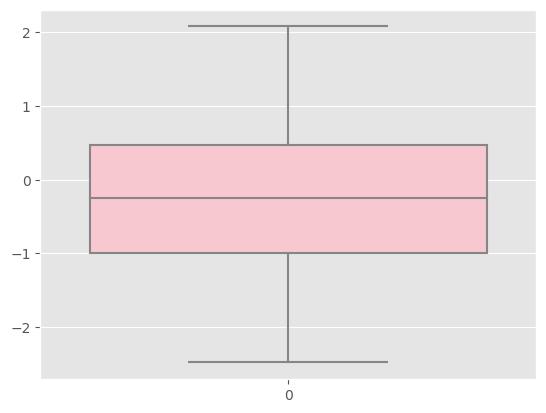

In [45]:
#box plot to show range of values  ##Univariate  ##used to check for outliers
sns.boxplot(df['Percentage Change'], color = 'pink')

<Axes: >

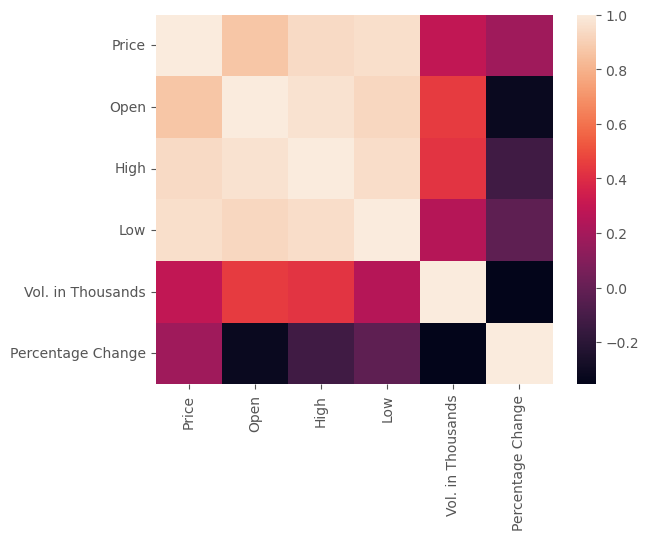

In [46]:
#plot correlation between all columns except date column
correlation = df.iloc[:,1:].corr()
corrgraph= sns.heatmap(correlation, xticklabels = correlation.columns, yticklabels = correlation.columns)
corrgraph

In [47]:
#scaling and checking for outliers
#use Standard Scaler to reduce potential dimensionality
#use IQR rather than Discretisation since dataset include time-series data
#also upper and lower bound of data are set
#start with 'High' since it has the largest amount of outliers and because it is highy correlated with 'Price'
Q_1 = df['High'].quantile(0.25)
Q_3 = df['High'].quantile(0.75)
IQR = Q_3 - Q_1
lowerbound = Q_1 - (1.5 * IQR)
upperbound = Q_3 + (1.5 * IQR)
print('IQR:', IQR)
print('Lower bound:', lowerbound)
print('Upper bound:', upperbound)

IQR: 0.1014999999999997
Lower bound: 3.6060000000000008
Upper bound: 4.012


In [48]:
upperarray = np.where(df['High'] >= upperbound)[0]  #index shows only the values
lowerarray = np.where(df['High'] <= lowerbound)[0]
print(upperarray)
print(lowerarray)

[21 22]
[]


In [49]:
# Removing the outliers
df.drop(index=upperarray, inplace=True)
df.drop(index=lowerarray, inplace=True)

In [50]:
df.tail()

,Date,Price,Open,High,Low,Vol. in Thousands,Percentage Change
16,2023-08-08,3.7665,3.8420,3.842,3.7265,138.60,-1.79
17,2023-08-07,3.8350,3.8520,3.877,3.8250,70.87,-0.84
18,2023-08-04,3.8675,3.8995,3.928,3.8255,79.91,-0.82
19,2023-08-03,3.8995,3.8445,3.904,3.8205,81.96,1.46
20,2023-08-02,3.8435,3.9100,3.921,3.8340,89.27,-1.66


<Axes: >

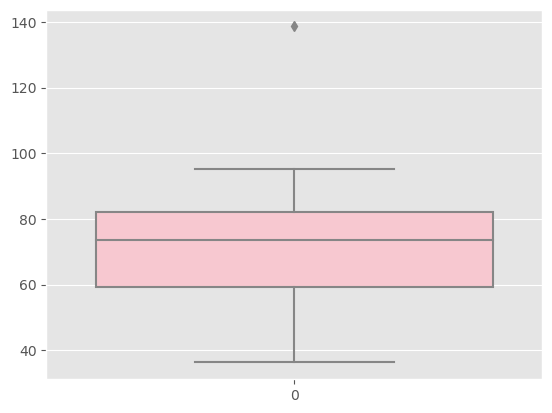

In [51]:
#Check outliers with less correlation with required variable which is Price
sns.boxplot(df['Vol. in Thousands'], color = 'pink')

In [52]:
#trials with Low, Price, High, Open
#ax1 = sns.boxplot(df['Low'], color = 'yellow')

In [53]:
#ax2 = sns.boxplot(df['Price'], color = 'yellow')

In [54]:
#ax3 = sns.boxplot(df['High'], color = 'yellow')

In [55]:
#ax4 = sns.boxplot(df['Open'], color = 'yellow')

In [56]:
##one outlier is left
#IQR trial with lower correlation column has failed
Q_11 = df['Vol. in Thousands'].quantile(0.25)
Q_31 = df['Vol. in Thousands'].quantile(0.75)
IQR1 = Q_31 - Q_11
lowerbound1 = Q_11 - (1.5 * IQR1)
upperbound1 = Q_31 + (1.5 * IQR1)
print('IQR:', IQR1)
print('Lower bound:', lowerbound1)
print('Upper bound:', upperbound1)

IQR: 22.659999999999997
Lower bound: 25.310000000000002
Upper bound: 115.94999999999999


In [57]:
upperarray1 = np.where(df['Vol. in Thousands'] >= upperbound)[0]  #indices that shall be removed
lowerarray1 = np.where(df['Vol. in Thousands'] <= lowerbound)[0]
print(upperarray1)
print(lowerarray1)
#IQR has failed and instead we will just locate the outlier from the boxplot and remove it

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[]


In [58]:
lowcorr = np.where(df['Vol. in Thousands'] > 120)[0]
df.drop(index=lowcorr, inplace=True)

In [59]:
#df.tail(10) #index 16 is removed
#new shape
df.shape

(20, 7)

In [60]:
#scaling
import sklearn
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [61]:
dfx =  df.drop(['Price','Date'], axis=1)
#dfx.head()

In [62]:
x = StandardScaler()
 
xscaled = x.fit_transform(dfx.to_numpy())
dfxscaled = pd.DataFrame(dfx, columns=dfx.columns)
 
dfxscaled.head()

,Open,High,Low,Vol. in Thousands,Percentage Change
0,3.7985,3.8083,3.7905,74.212079,0.27
1,3.7950,3.8290,3.7800,76.836941,-0.28
2,3.7887,3.8057,3.7887,73.149638,0.49
3,3.7890,3.8290,3.7655,44.880000,-0.25
4,3.8365,3.8390,3.7860,36.270000,-1.15


In [63]:
#try z score to check high correlation, low correlation and predicted column
pricezscore = (df['Price'] - np.mean(df['Price'])) / np.std(df['Price'])
print('Price z score:\n',pricezscore)
highzscore = (df['High'] - np.mean(df['High'])) / np.std(df['High'])
#print('High z score:\n', highzscore)
volzscore = (df['Vol. in Thousands'] - np.mean(df['Vol. in Thousands'])) / np.std(df['Vol. in Thousands'])
#print('Volume z score:\n', volzscore)

Price z score:
 0     0.433454
1     0.276701
2     0.441138
3     0.153757
4     0.299753
5     0.975944
6     0.222913
7    -0.852847
8    -1.044946
9    -1.267782
10   -1.790294
11   -1.636614
12   -0.745271
13   -0.845163
14   -0.138235
15    0.146073
17    0.937524
18    1.436984
19    1.928760
20    1.068152
Name: Price, dtype: float64


## Feature Selection and Visualisation

          High     Low    Open
Price                         
3.6575  3.6940  3.6420  3.6600
3.6675  3.7490  3.6560  3.7270
3.6915  3.7195  3.6270  3.6475
3.7060  3.7215  3.6645  3.6880
3.7185  3.7305  3.6845  3.7160
3.7190  3.7675  3.6950  3.7550
3.7255  3.7420  3.6870  3.7185
3.7650  3.8315  3.7465  3.7875
3.7835  3.8270  3.7635  3.7795
3.7840  3.8290  3.7655  3.7890
3.7885  3.8095  3.7515  3.7565
3.7920  3.8290  3.7800  3.7950
3.7935  3.8390  3.7860  3.8365
3.8022  3.8083  3.7905  3.7985
3.8027  3.8057  3.7887  3.7887
3.8350  3.8770  3.8250  3.8520
3.8375  3.8425  3.7885  3.7900
3.8435  3.9210  3.8340  3.9100
3.8675  3.9280  3.8255  3.8995
3.8995  3.9040  3.8205  3.8445


<Axes: xlabel='Price'>

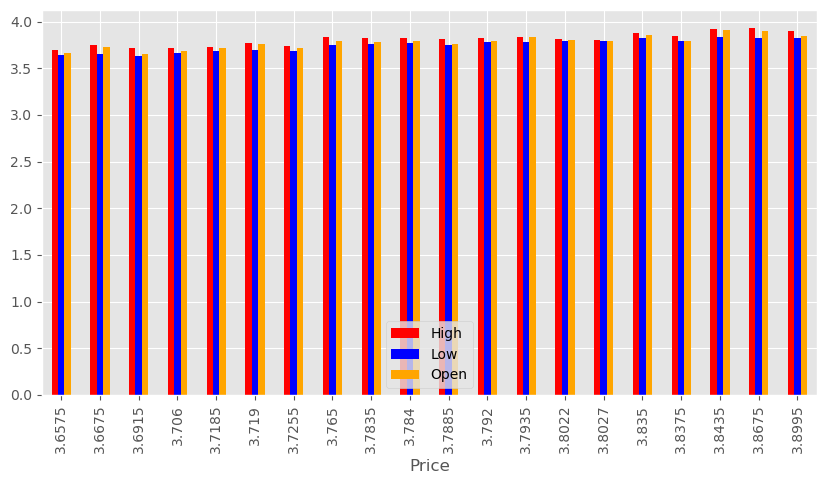

In [64]:
#pivot tables of numerical features with high correlation
dfpivotmean = df.pivot_table(values = ['Open', 'High', 'Low'], index = 'Price', aggfunc = np.mean)
print(dfpivotmean)
dfpivotmean.plot(kind = 'bar', color = {'Open':'orange', 'High':'red', 'Low':'blue'}, fontsize = 10, figsize=(10,5))

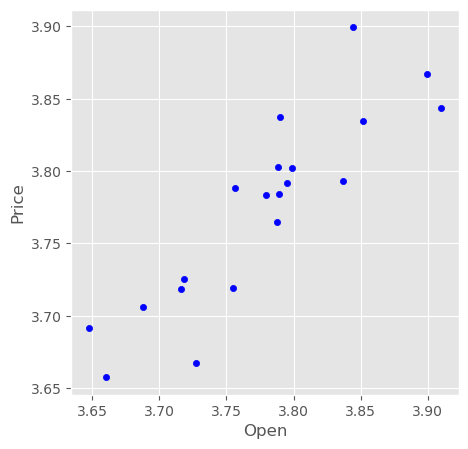

In [65]:
#plot scatter graphs of each high correlation variable
ax0 = df.plot(kind = 'scatter', x = 'Open', y = 'Price', color = 'blue', fontsize = 10, figsize = (5, 5))
plt.show()

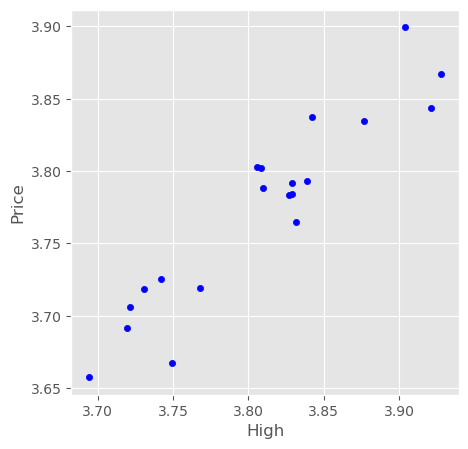

In [66]:
ax1 = df.plot(kind = 'scatter', x = 'High', y = 'Price', color = 'blue', fontsize = 10, figsize = (5, 5))
plt.show()

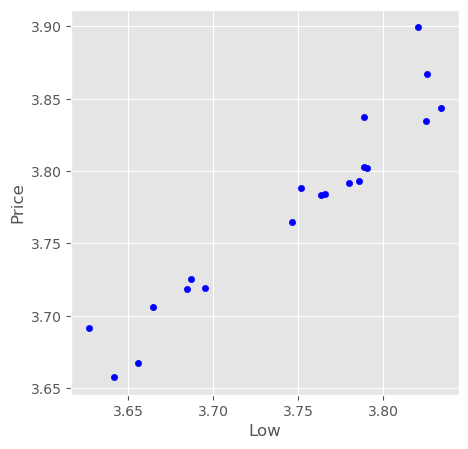

In [494]:
df.plot(kind = 'scatter', x = 'Low', y = 'Price', color = 'blue', fontsize = 10, figsize = (5, 5))
plt.show()

In [68]:
df.head()

,Date,Price,Open,High,Low,Vol. in Thousands,Percentage Change
0,2023-08-29,3.8022,3.7985,3.8083,3.7905,74.212079,0.27
1,2023-08-28,3.7920,3.7950,3.8290,3.7800,76.836941,-0.28
2,2023-08-27,3.8027,3.7887,3.8057,3.7887,73.149638,0.49
3,2023-08-25,3.7840,3.7890,3.8290,3.7655,44.880000,-0.25
4,2023-08-24,3.7935,3.8365,3.8390,3.7860,36.270000,-1.15


In [69]:
#df.head()
#types after null handling
df_n, df_c = types(df)
print(df_n)
print('___________________________\n')
print(df_c)

['Date', 'Price', 'Open', 'High', 'Low', 'Vol. in Thousands', 'Percentage Change']
___________________________

[]


In [70]:
df_n[1:-1]

['Price', 'Open', 'High', 'Low', 'Vol. in Thousands']

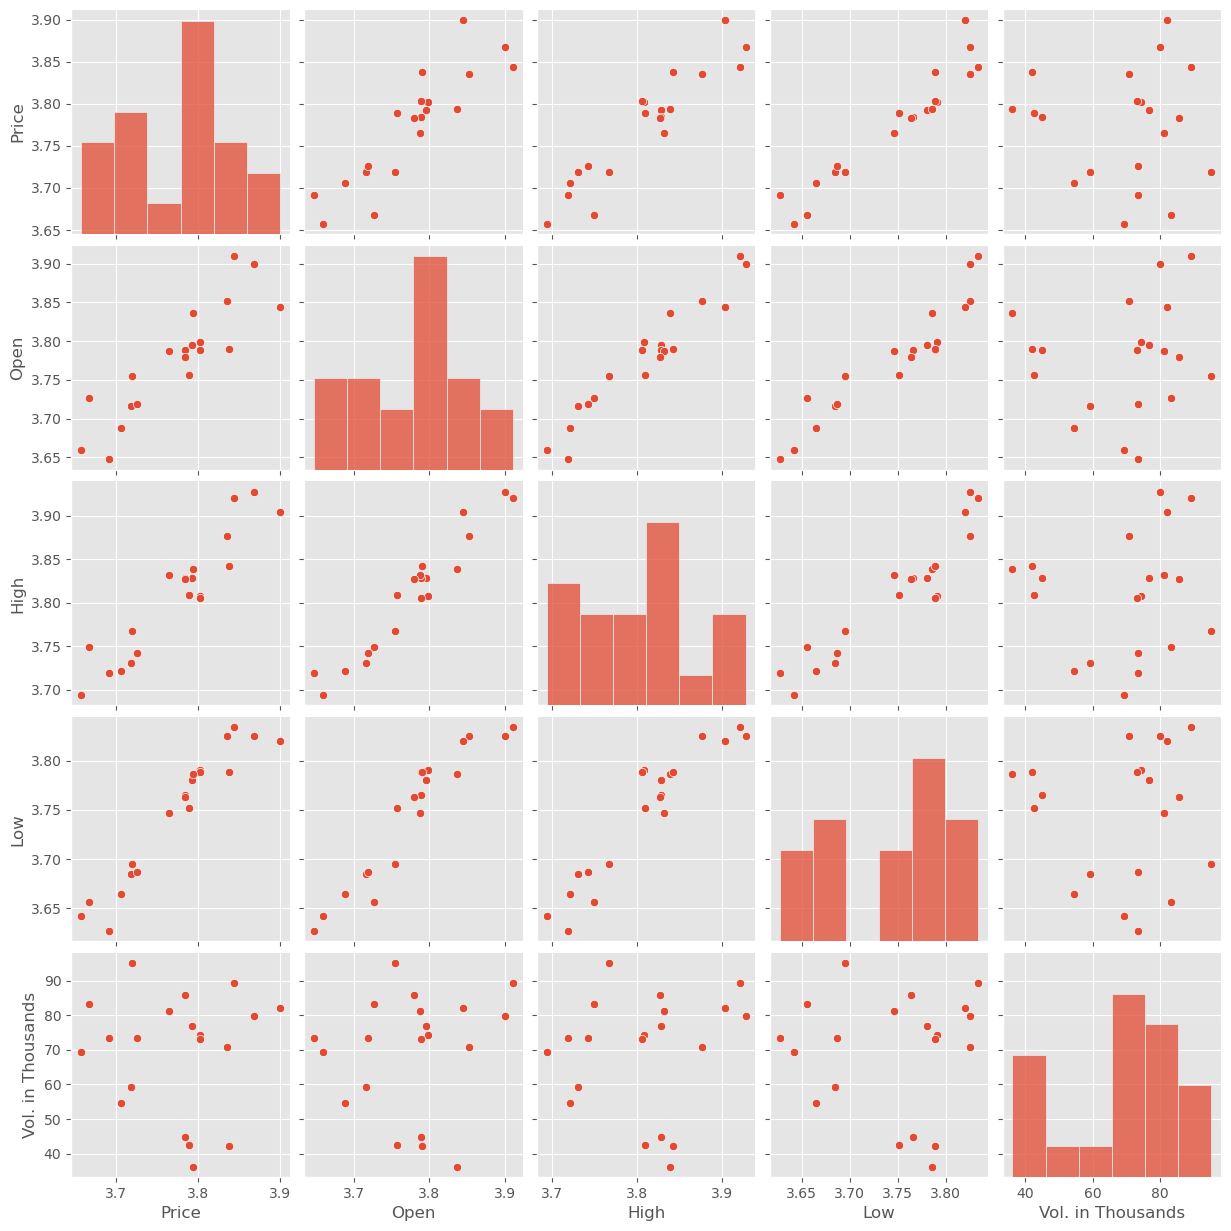

In [71]:
sns.pairplot(df.iloc[:,1:], vars = df_n[1:-1])

#### There is a positive correlation between Price, Open, High, Low. This means that these features will be selected as inputs for the prediction model. Feature engineering tools such as tsfresh or Feature Tools can be used to check the features chosen. The aim of the prediction model is to predict prices of copper that are taken each quarter, so a time series prediction model shall be used.

## Modelling and Evaluation

In [469]:
#Model used is long short term memory prediction
#divide into train and test sets

In [470]:
##predict price and evaluate model by mse and by comparing with df 

In [471]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers
#scale using MinMaxScaler since mean is a valuable calculation for this dataset so scale to a given range
from sklearn.preprocessing import MinMaxScaler

In [495]:
def createdataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset.iloc[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [473]:
tf.random.set_seed(100)

In [474]:
scaler = MinMaxScaler(feature_range=(0, 1))
dfx2 =  df.drop(['Date'], axis=1)
dataset = scaler.fit_transform(dfx2.to_numpy())
datasetscaled = pd.DataFrame(dfx2, columns = dfx2.columns)
datasetscaled.head()

,Price,Open,High,Low,Vol. in Thousands,Percentage Change
0,3.8022,3.7985,3.8083,3.7905,74.212079,0.27
1,3.7920,3.7950,3.8290,3.7800,76.836941,-0.28
2,3.8027,3.7887,3.8057,3.7887,73.149638,0.49
3,3.7840,3.7890,3.8290,3.7655,44.880000,-0.25
4,3.7935,3.8365,3.8390,3.7860,36.270000,-1.15


In [475]:
train_size = int(len(datasetscaled) * 0.7)
test_size = len(datasetscaled) - train_size
train = datasetscaled.iloc[0:train_size, :] 
test = datasetscaled.iloc[train_size:len(datasetscaled), :]

In [496]:
look_back = 1
trainX, trainY = createdataset(train, look_back)
testX, testY = createdataset(test, look_back)

In [477]:
trainX

array([[3.8022],
       [3.792 ],
       [3.8027],
       [3.784 ],
       [3.7935],
       [3.8375],
       [3.7885],
       [3.7185],
       [3.706 ],
       [3.6915],
       [3.6575],
       [3.6675]])

In [478]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [479]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
adam = keras.optimizers.Adam(learning_rate = 0.05)
model.compile(loss='mean_squared_error', optimizer=adam)
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
12/12 - 2s - loss: 7.8799 - 2s/epoch - 163ms/step
Epoch 2/100
12/12 - 0s - loss: 0.9960 - 41ms/epoch - 3ms/step
Epoch 3/100
12/12 - 0s - loss: 0.0333 - 48ms/epoch - 4ms/step
Epoch 4/100
12/12 - 0s - loss: 0.1066 - 48ms/epoch - 4ms/step
Epoch 5/100
12/12 - 0s - loss: 0.0258 - 49ms/epoch - 4ms/step
Epoch 6/100
12/12 - 0s - loss: 0.0039 - 48ms/epoch - 4ms/step
Epoch 7/100
12/12 - 0s - loss: 0.0060 - 48ms/epoch - 4ms/step
Epoch 8/100
12/12 - 0s - loss: 0.0039 - 49ms/epoch - 4ms/step
Epoch 9/100
12/12 - 0s - loss: 0.0035 - 48ms/epoch - 4ms/step
Epoch 10/100
12/12 - 0s - loss: 0.0033 - 47ms/epoch - 4ms/step
Epoch 11/100
12/12 - 0s - loss: 0.0033 - 48ms/epoch - 4ms/step
Epoch 12/100
12/12 - 0s - loss: 0.0032 - 40ms/epoch - 3ms/step
Epoch 13/100
12/12 - 0s - loss: 0.0042 - 41ms/epoch - 3ms/step
Epoch 14/100
12/12 - 0s - loss: 0.0030 - 47ms/epoch - 4ms/step
Epoch 15/100
12/12 - 0s - loss: 0.0036 - 47ms/epoch - 4ms/step
Epoch 16/100
12/12 - 0s - loss: 0.0032 - 44ms/epoch - 4ms/step
E

In [480]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

1/1 [==============================] - 0s 12ms/step


In [481]:
#trainPredict.shape
#trainY.shape
#testPredict.shape
#testY.shape
#datasetscaled.to_numpy()

In [482]:
datasetscaled.shape

(20, 6)

In [483]:
#inversion of predictions improves accuracy of algorithm ##inversion here is not needed
#the model converges between features values of 0 and 1
#raw data doesn't utilise 0 and 1 values
#MinMaxScaler normalises the model, as well as apply(normlaize = True)
#in both cases the model converges, but in this case the normalised predictions are used
'''newtrainPredict = scaler.inverse_transform(trainPredict)
newtrainY = scaler.inverse_transform([trainY])
newtestPredict = scaler.inverse_transform(testPredict)
newtestY = scaler.inverse_transform([testY])'''

'newtrainPredict = scaler.inverse_transform(trainPredict)\nnewtrainY = scaler.inverse_transform([trainY])\nnewtestPredict = scaler.inverse_transform(testPredict)\nnewtestY = scaler.inverse_transform([testY])'

In [484]:
print(type(trainPredict))
trainPredict = pd.DataFrame(trainPredict)
trainPredict=trainPredict.rename(columns = {0 : 'Train Predict'})
trainPredict

<class 'numpy.ndarray'>


,Train Predict
0,3.755239
1,3.755025
2,3.755250
3,3.754856
4,3.755057
5,3.755963
6,3.754951
7,3.753414
8,3.753127
9,3.752790


In [485]:
print(type(trainY))
trainY = pd.DataFrame(trainY)
trainY = trainY.rename(columns = {0 : 'Train Price'})
trainY

<class 'numpy.ndarray'>


,Train Price
0,3.7920
1,3.8027
2,3.7840
3,3.7935
4,3.8375
5,3.7885
6,3.7185
7,3.7060
8,3.6915
9,3.6575


In [486]:
print(type(testPredict))
testPredict = pd.DataFrame(testPredict)
testPredict = testPredict.rename(columns = {0 : 'Test Predict'})
testPredict

<class 'numpy.ndarray'>


,Test Predict
0,3.754448
1,3.754845
2,3.755913
3,3.756558


In [487]:
print(type(testY))
testY = pd.DataFrame(testY)
testY = testY.rename(columns = {0 : 'Test Price'})
testY

<class 'numpy.ndarray'>


,Test Price
0,3.7835
1,3.8350
2,3.8675
3,3.8995


In [488]:
#calculate root mean squared error between actual trainY and prediction trainPredict
#repeat with actual testY and prediction testPredict
trainScore = np.sqrt(mean_squared_error(trainY['Train Price'], trainPredict['Train Predict']))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY['Test Price'], testPredict['Test Predict']))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.06 RMSE
Test Score: 0.10 RMSE


#### The Train Score looks much higher than the Test Score by about double its value. This means that despite the RMSE values being low, the model looks to be overfit. This can be due to a lack of dimensionality reduction or a lack of randomisation. The look_back has been set to 2 since the features chosen to be most correlated were 3, but this still didn't solve the issue. The optimiser of the LSTM model had its learning rate changed from 0.01 to 0.05 and the look_back was kept at 1 by default. The seed and the number of epochs were set to 100. This setup yielded the best performance. 

- A brief report describing planned/executed methodology, data preprocessing steps, feature selection, and model evaluation. In addition to summarizing the findings, and insights for the key factors driving the price predictions [1-pager word document].